### Encoder trained on features extracted from images of Flicker 8K dataset

In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from nnkek.encoders import Autoencoder
from nnkek import embeddings

from tools.util import file_utils

MODELS_DIR = 'models/encoders'
PLOTS_DIR = 'plots/encoders'
FLICKER_SET_DIR = 'data/Flicker8k/Flicker8k_Dataset/'
ENCODER_DUMP_NAME = 'encoder_flicker8k.pkl'
ENCODER_PLOT_NAME = 'encoder_flicker8k.png'

### Load Flicker8k dataset and extract features with NN

In [2]:
# load dataset
img_paths = file_utils.path_get_file_list(FLICKER_SET_DIR, file_types=['img'])[0]

# extract and persist features
vectorizer = embeddings.ImageVectorizer()
embeddings.from_paths(vectorizer, img_paths)

# load feature paths
feature_paths = [x.split('.')[0] + '.npy' for x in img_paths]

0 unique images to process..


In [3]:
assert len(img_paths) == 8091 
assert len(feature_paths) == 8091
assert img_paths[0].split('.')[0] == feature_paths[0].split('.')[0]

#### Load features into RAM

In [4]:
df = pd.DataFrame({'img_path': img_paths, 
                   'feature_path': feature_paths})

df['features'] = df.feature_path.map(np.load)
df.head()

,img_path,feature_path,features
0,data/Flicker8k/Flicker8k_Dataset/2387197355_23...,data/Flicker8k/Flicker8k_Dataset/2387197355_23...,"[0.34385312, 0.39984658, 0.38301855, 0.3712026..."
1,data/Flicker8k/Flicker8k_Dataset/2609847254_0e...,data/Flicker8k/Flicker8k_Dataset/2609847254_0e...,"[0.6205202, 0.79353493, 0.5873091, 0.27168468,..."
2,data/Flicker8k/Flicker8k_Dataset/2046222127_a6...,data/Flicker8k/Flicker8k_Dataset/2046222127_a6...,"[0.18034357, 0.2928543, 0.398409, 0.258997, 0...."
3,data/Flicker8k/Flicker8k_Dataset/2853743795_e9...,data/Flicker8k/Flicker8k_Dataset/2853743795_e9...,"[0.07902372, 0.57867223, 0.13135749, 0.3942633..."
4,data/Flicker8k/Flicker8k_Dataset/2696951725_e0...,data/Flicker8k/Flicker8k_Dataset/2696951725_e0...,"[0.45470607, 0.33607295, 0.75701547, 0.3788064..."


#### Train test split

In [5]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

print('Flicker train, val:', train.shape[0], val.shape[0])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

Flicker train, val: 6472 1619


### Train Encoder

#### Set up Pytorch Framework

In [6]:
BATCH_SIZE = 128

trainloader = DataLoader(
    train['features'].values, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    val['features'].values, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

encoder = Autoencoder()

#### Train

In [ ]:
train_loss, val_loss = encoder.fit(
    trainloader,
    valloader,
    debug=True
)

#### Save

In [10]:
encoder.save(os.path.join(MODELS_DIR, ENCODER_DUMP_NAME))

#### Plot Loss

In [ ]:
plt.figure()

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')

plt.title('Encoder train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(os.path.join(PLOTS_DIR, ENCODER_PLOT_NAME))

### Verify autoencoder quality

In [8]:
encoder = Autoencoder()
encoder.load(os.path.join(MODELS_DIR, ENCODER_DUMP_NAME))

In [9]:
# encode the whole validation set 

raw = torch.empty(0, encoder.input_size)
encoded = torch.empty(0, encoder.hidden_size)

for batch in valloader:
    raw = torch.cat((raw, batch))
    encoded = torch.cat((encoded, encoder.encode(batch)))

In [10]:
# visually evaluate results

from nnkek.validation import TopKComparator, Displayer

comparator = TopKComparator(raw, encoded, k=6)
displayer = Displayer(val.img_path.values, comparator)

In [13]:
comparator.take_random()

(tensor([ 538,  550, 1135,  562,  446,  648]),
 tensor([ 538,  562,  181,  550, 1347,  373]),
 array([538, 550, 562]))

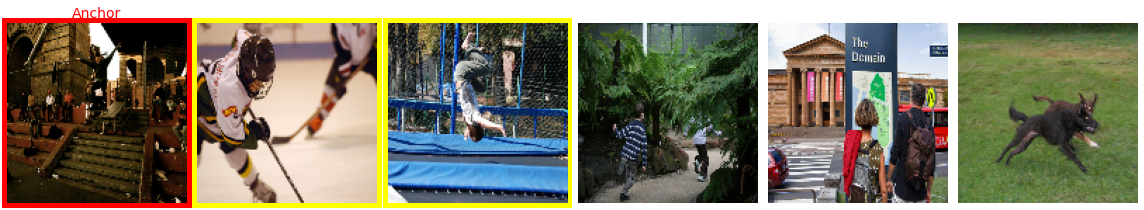

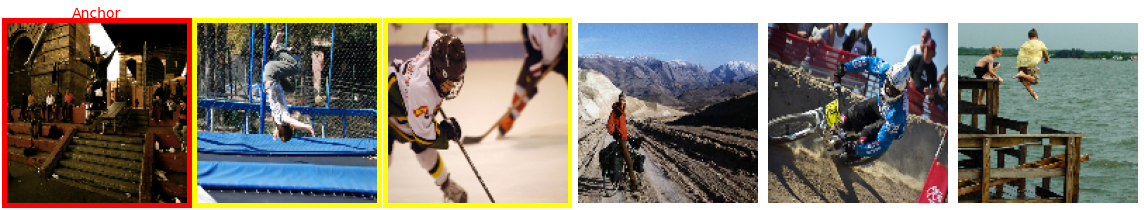

In [24]:
displayer.plot_random_comparison()

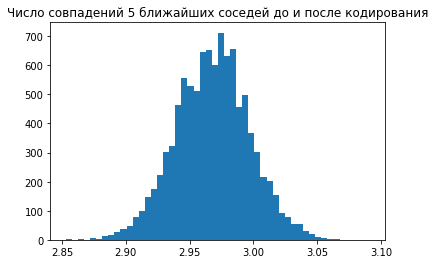

Confidence interval:
2.5 97.5
interval length: 0.114
[2.911, 3.025]



In [19]:
# build distribution

from nnkek.validation import BootsTrapper, distribution_report

bootstrapper = BootsTrapper(comparator)
distribution = bootstrapper.run(amount=10000, verbose_amount=None)

distribution_report(
    distribution, 
    use_0_to_1_range=False, 
    percentage=95, 
    bins=50, 
    title='Число совпадений 5 ближайших соседей до и после кодирования'
)